In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt

## simple derivative review

In [7]:
def f(x):
  return 3*x**2 + 7*x -4

In [8]:
f(2.0)

22.0

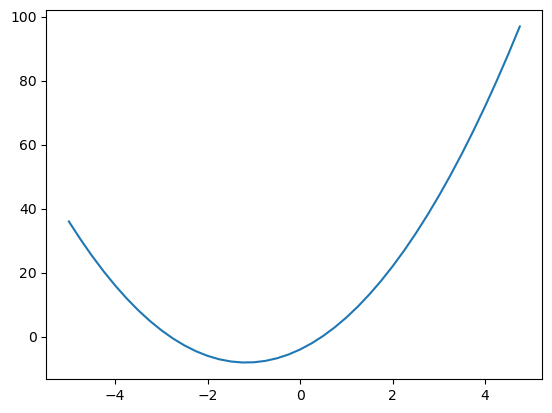

In [13]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [27]:
h = 0.00000000001
x = -7/6
(f(x+h) - f(x)) / h

0.00017763568394002505

In [33]:
a = 3.0
b = -5.0
c = 11.0

def g(a, b, c):
  return a*b + c

h = 0.00000001

d1 = g(a, b, c)
c += h
d2 = g(a,b,c)

print(d1)
print(d2)
print('slope', (d2 - d1) / h)

-4.0
-3.999999989999999
slope 1.000000082740371


## Working with Gradients

In [102]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad ), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [202]:
class Value:
  def __init__(self, data, _children=(), _op=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
  
  def __repr__(self):
        return f"Value(data={self.data})"
      
  def __add__(self, opr):
    opr = opr if isinstance(opr, Value) else Value(opr)
    val = Value(self.data + opr.data, (self, opr), '+')
    
    def _backward():
      self.grad += 1.0 * val.grad 
      opr.grad += 1.0 * val.grad
      
    val._backward = _backward
    
    return val
  
  def __mul__(self, opr):
    opr = opr if isinstance(opr, Value) else Value(opr)
    val = Value(self.data * opr.data, (self, opr), '*')
      
    def _backward():
      self.grad += opr.data * val.grad
      opr.grad += self.data * val.grad
      
    val._backward = _backward
  
    return val
    
  def __pow__(self, opr):
    assert isinstance(opr, (int, float)), 'bad'
    x = self.data
    val = Value(x**opr, (self, ), f'**{opr}')
      
    def _backward():
      self.grad += opr * x**(opr - 1) * val.grad
      
    val._backward = _backward
  
    return val
  
  def exp(self):
    x = self.data
    val = Value(math.exp(x), (self, ), 'exp')
      
    def _backward():
      self.grad += val.data * val.grad
      
    val._backward = _backward
  
    return val
  
  def __neg__(self): # -self
    return self * -1

  def __radd__(self, other): # other + self
    return self + other

  def __sub__(self, other): # self - other
    return self + (-other)

  def __rsub__(self, other): # other - self
    return other + (-self)

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __rtruediv__(self, other): # other / self
    return other * self**-1
    
  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
    
    val = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * val.grad
      
    val._backward = _backward
    
    return val
  
  def backward(self):
    # topological order all of the children in the graph
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    
    for v in reversed(topo):
      v._backward()


In [180]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = g(a, b, c)
f = Value(-2.0)
L = d * f

# L.grad = 1
# f.grad = d.data
# d.grad = f.data

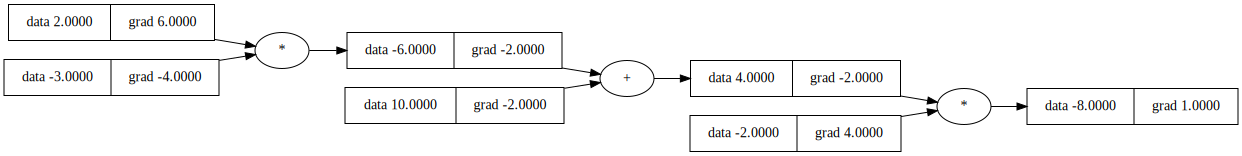

In [181]:
L.backward()
draw_dot(L)

### A more accurate representation

In [190]:
x1 = Value(2.0)
x2 = Value(0.0)

w1 = Value(-3.0)
w2 = Value(1.0)

b = Value(6.8813735)

n = w1*x1 + w2*x2 + b

e = (2*n).exp()
o = (e - 1) / (e + 1)


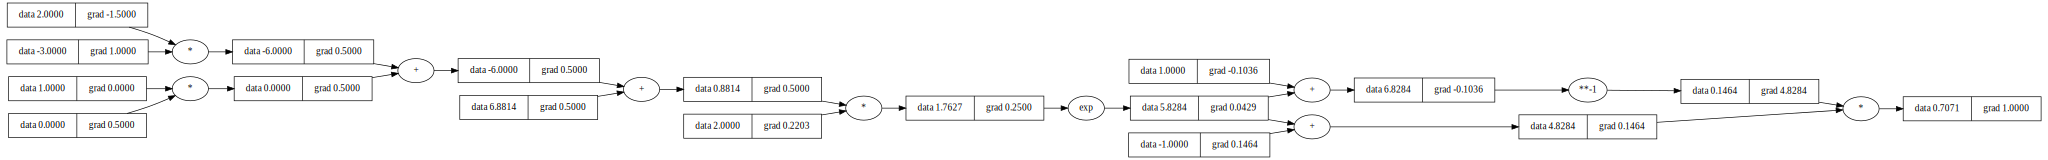

In [191]:
o.backward()
draw_dot(o)

### Using Pytorch

In [203]:
import torch

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True

b = torch.Tensor([6.8813735]).double() ; b.requires_grad = True

n = w1*x1 + w2*x2 + b
o = torch.tanh(n)

o.backward()

print(o.data.item())

print(x1.grad.item())
print(w1.grad.item())
print(x2.grad.item())
print(w2.grad.item())

0.7071066904050358
-1.5000003851533106
1.0000002567688737
0.5000001283844369
0.0


## Neurons (Multi Layer Perceptrons)

In [214]:
import random

class Neuron:
  def __init__(self, nin, nonlin=True):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(0)
    self.nonlin = nonlin

  def __call__(self, x):
    act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
    return act.tanh() if self.nonlin else act

  def parameters(self):
    return self.w + [self.b]

  def __repr__(self):
    return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"
  
class Layer:
  def __init__(self, nin, nout, **kwargs):
    self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

  def __call__(self, x):
    out = [n(x) for n in self.neurons]
    return out[0] if len(out) == 1 else out

  def parameters(self):
    return [p for n in self.neurons for p in n.parameters()]

  def __repr__(self):
   return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"
 
class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
        x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

  def __repr__(self):
    return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"


In [399]:
# x = [2.0, 3.0, -1.0]
n = MLP(3 , [4, 4, 1])
# n(x)

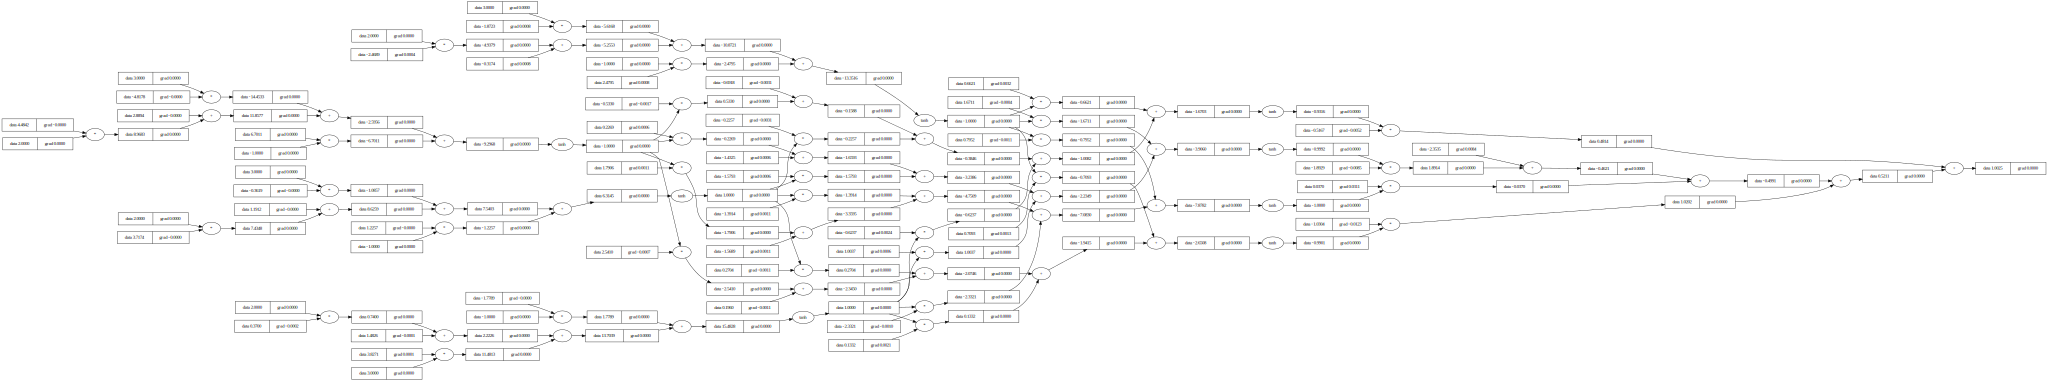

In [373]:
draw_dot(n(x))

In [365]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [400]:
for i in range(20):
  #fwd
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # bwd
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
    
  print(i, loss.data)

0 4.669669852468126
1 8.492640479625281
2 12.916293140608854
3 5.842498570898948
4 1.6293111459769503
5 0.3167306360063429
6 0.0727222290171641
7 0.02354752398008888
8 0.009309487177006739
9 0.004873538730803043
10 0.0034933849068953787
11 0.0030346164480760016
12 0.0028595339078309563
13 0.0027712662012266236
14 0.002710617515142876
15 0.0026594481754799253
16 0.002612282087530988
17 0.00256738490190731
18 0.002524195213894312
19 0.002482487316440069


In [401]:
ypred

[Value(data=1.0350658447464258),
 Value(data=-0.998645828341535),
 Value(data=-0.9995242966091527),
 Value(data=0.9646331543099618)]